# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


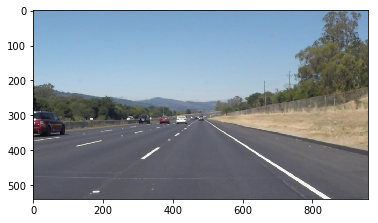

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [9]:
import math
from math import pi

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def grayscale_hsv(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV);
    return hsv[:,:,2]
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_noise(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    return lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def draw_lines(lines, imshape, color=[255, 0, 0], thickness=10):
    """
    Create an OpenCV image of size `imshape` and draw the lines specified by `lines`
    
    `lines` is the output of hough_lines
    `imshape` is a tuple representing the shape of the image

    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """

    if len(imshape) < 3:
        imshape = (imshape[0], imshape[1], 3)
    else:
        imshape = imshape

    line_img = np.zeros(imshape, dtype=np.uint8)
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)

    return line_img

# image = mpimg.imread('test_images/solidYellowLowContrast.jpg')

# im2 = ychannel(image)
# im3 = grayscale(image)
# plt.figure()
# plt.imshow(np.hstack((im2, im3)), cmap='gray')
    return cv2.addWeighted(initial_img, alpha, img, beta,lamda)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [10]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

In [12]:
def detect_lanes(lines, imshape,
                 angle_min_mag = 25*pi/180, angle_max_mag = 40*pi/180, 
                 rho_min_diag = 0.1, rho_max_diag = 0.60, cache_wt = 0.90,
                 last_lanes = None):
    
    lane_markers_x = [[], []]
    lane_markers_y = [[], []]
    
    if last_lanes is not None:
        last_apex_pt = np.array([last_lanes[0][0][2], last_lanes[0][0][3]])
        last_left_pt = last_lanes[0][0][1]
        last_right_pt = last_lanes[1][0][1]    
    
    diag_len = math.sqrt(imshape[0]**2 + imshape[1]**2)
    for line in lines:
        for x1,y1,x2,y2 in line:
            theta = math.atan2(y1-y2, x2-x1)
            rho = ((x1+x2)*math.cos(theta) + (y1+y2)*math.sin(theta))/2
            
            if (abs(theta) >= angle_min_mag and abs(theta) <= angle_max_mag
                and rho >= rho_min_diag*diag_len and rho <= rho_max_diag*diag_len
               ):

                if theta > 0: # positive theta is downward in image space?
                    # Left lane marker
                    i = 0
                else:
                    # Right lane marker
                    i = 1
                lane_markers_x[i].append(x1)
                lane_markers_x[i].append(x2)
                lane_markers_y[i].append(y1)
                lane_markers_y[i].append(y2)

    if (len(lane_markers_x[0]) == 0 or
        len(lane_markers_x[1]) == 0 or
        len(lane_markers_y[0]) == 0 or
        len(lane_markers_y[1]) == 0):
        
        # Use cached value if available if detection failed
        if last_lanes is not None:
            apex_pt = last_apex_pt
            left_pt = last_left_pt
            right_pt = last_right_pt
        else:
            return None
    else:
        # Least Squares fit
        p_left  = np.polyfit(lane_markers_x[0], lane_markers_y[0], 1)
        p_right = np.polyfit(lane_markers_x[1], lane_markers_y[1], 1)
        
        # Find intersection
        apex_pt = np.linalg.solve([[p_left[0], -1], [p_right[0], -1]], [-p_left[1], -p_right[1]])
        left_pt = math.ceil(np.polyval(p_left, 0))
        right_pt = math.ceil(np.polyval(p_right, imshape[1]))
        
        # Average solution with cached version
        if last_lanes is not None:
            apex_pt[0] = math.ceil(cache_wt*last_apex_pt[0] + (1.0-cache_wt)*apex_pt[0])
            apex_pt[1] = math.ceil(cache_wt*last_apex_pt[1] + (1.0-cache_wt)*apex_pt[1])

            left_pt = math.ceil(last_left_pt*cache_wt + left_pt*(1-cache_wt))
            right_pt = math.ceil(last_right_pt*cache_wt + right_pt*(1-cache_wt))
    
    return [[(0, left_pt, int(apex_pt[0]), int(apex_pt[1]))],
            [(imshape[1], right_pt, int(apex_pt[0]), int(apex_pt[1]))]]


In [13]:
from skimage.morphology import skeletonize

def process_image(image, 
                  bounds=None, 
                  gauss_size=5,
                  canny_low=50, canny_high=150, use_cache=False):
    
    if not use_cache:
        process_image.last_lanes = None
    
    imshape = image.shape
        
    gray_img = grayscale_hsv(image)
    # Auto-Level image for dealing with low-contrast frames    
    # Ref: http://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html
    gray_eq_img = cv2.equalizeHist(gray_img)

    gray_img = gray_eq_img
    blur_gray = gaussian_noise(gray_img, kernel_size=gauss_size)

    # Define our parameters for Canny and apply
    edges = canny(blur_gray, canny_low, canny_high)

    
    # This time we are defining a four sided polygon to mask

    # Define trapezoid as fraction of image dimensions
    if bounds is None:
        bounds = {'bl':(0.00,  1.00),  # Bottom left
                  'tl':(0.495, 0.58),  # Top left
                  'tr':(0.505, 0.58),  # Top right
                  'br':(1.00,  1.00)}   # Bottom right
        
    # Define bounding polygon based on specified bounds
    vertices = np.array([[(imshape[1]*bounds['bl'][0], imshape[0]*bounds['bl'][1]),
                          (imshape[1]*bounds['tl'][0], imshape[0]*bounds['tl'][1]),
                          (imshape[1]*bounds['tr'][0], imshape[0]*bounds['tr'][1]),
                          (imshape[1]*bounds['br'][0], imshape[0]*bounds['br'][1])]], dtype=np.int32)
    
    masked_edges = region_of_interest(edges, vertices)
#     plt.imshow(np.hstack((masked_edges,)), cmap='gray')
    
    # Define the Hough transform parameters
    rho = 2              # distance resolution in pixels of the Hough grid
    theta = 1*np.pi/180  # angular resolution in radians of the Hough grid
    threshold = 25       # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 45 # minimum number of pixels making up a line
    max_line_gap = 20    # maximum gap in pixels between connectable line segments
    
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    if lines is not None:
        lanes = detect_lanes(lines, imshape, last_lanes=process_image.last_lanes)
        
        if use_cache:
            process_image.last_lanes = lanes
            
        if lanes is not None:
            line_img = draw_lines(lanes, imshape)
        else:
            line_img = draw_lines([[]], imshape)
        # Draw lines on original image
        result = weighted_img(line_img, image)
    else:
        result = image

    return result

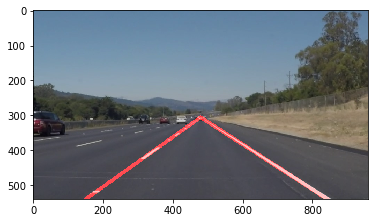

In [14]:
process_image.last_lanes = None

config = dict(bounds = {'bl':(0.20, 0.88),  # Bottom left
                        'tl':(0.49, 0.58),  # Top left
                        'tr':(0.51, 0.58),  # Top right
                        'br':(1.00, 0.88)}, # Bottom right
              canny_low=75,
              canny_high=150,
              gauss_size=7,
              use_cache=False)

image = mpimg.imread('test_images/solidWhiteRight.jpg')
# image = mpimg.imread('test_images/solidYellowLowContrast.jpg')
im1 = process_image(image, **config)
plt.figure()
plt.imshow(im1)

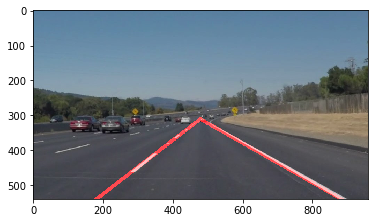

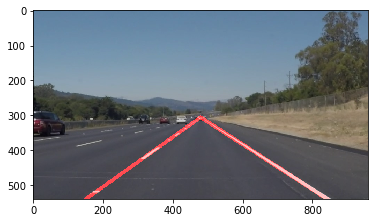

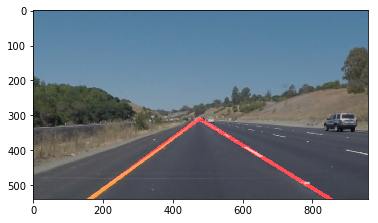

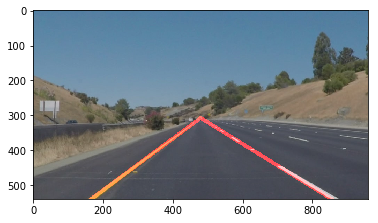

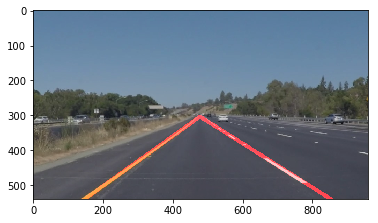

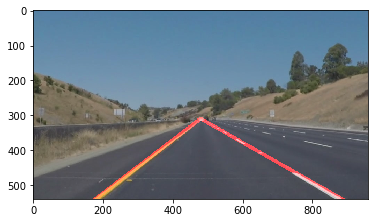

In [17]:
for fileName in os.listdir("test_images/"):
    fullName="test_images/"+fileName
    image = mpimg.imread(fullName)
    processed_img = process_image(image, **config)
    plt.figure()
    plt.imshow(processed_img)
    mpimg.imsave('output_images/'+fileName, processed_img)
    
    


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [19]:
config['use_cache'] = True
config['gauss_size'] = 7
config['canny_low'] = 75
config['bounds'] = {'bl':(0.15, 0.88),  # Bottom left
                    'tl':(0.495, 0.58),  # Top left
                    'tr':(0.505, 0.58),  # Top right
                    'br':(1.00, 0.88)}  # Bottom right

white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(lambda i: process_image(i, **config))
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:03<00:00, 57.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 4.27 s


In [20]:
HTML("""
<video width="960" height="540" controls="true">
  <source src="{0}" type="video/mp4">
</video>
""".format(white_output))

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [21]:
config['use_cache'] = True
config['canny_low'] = 75
config['gauss_size'] = 7
config['bounds'] = {'bl':(0.10, 0.88),  # Bottom left
                    'tl':(0.495, 0.58),  # Top left
                    'tr':(0.505, 0.58),  # Top right
                    'br':(0.90, 0.88)}  # Bottom right

yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(lambda i: process_image(i, **config))
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:12<00:00, 54.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 13 s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

# Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


### Overview of the Image Pipeline

Previously , My lane lane detection algorithm builds upon the hough-transform method Only , but as suggested . I have added somsome extra features, along with some averaging to get over small gaps in the data. The steps in the algorithm are as follows:

1. Converted image to grayscale using grayscale_hsv function . This method extract the 'V' channel of the image in HSV colorspace .I have found that HSV perform better than default grayscale.
2.I have even perform Histrogram equlization operation jut to adjust for different lighting levels and this is done by improving constact . 
3. Added some blurring in the image using `gaussina_noise` and `canny_edge` 

4. Since we donot want whole image data to be analyses we have cropped few seaction and This is done by using bound 

`bounds = {'bl':(0.20, 0.90),  # Bottom left
          'tl':(0.495, 0.6),  # Top left
          'tr':(0.505, 0.6),  # Top right
          'br':(0.95, 0.90)}  # Bottom right`
          

5.The `hough_lines` method is called to detect the lines in the image. The method  only returns the coordinates of the lines . This is to make sure that only the detected lane markers are shown in the output. As of now, the parameters relating to the Hough transform are hard-coded into the function. This can also be made configurable if needed. 


6.The detect_lanes method is called to detect the actual lane markers from the line segments detected using the Hough transform. This method is described in detail in the next section. The output of detect_lanes is cached if the use_cache parameter is set to True. This is used in smooth out jitters and increase robustness of the lane detection algorithm.


7.The left and right lane marker coordinates returned by detect_lanes is overlayed on the original frame using the draw_lines method.
 

### Lane Detection Algorithm 




#### Initialization and Configuration

The Main task of detecting lane from any line segment given by the Hought Transform is done my mehton `detec_lanes` method.

Function Header 

```python
def detect_lanes(lines, imshape,
                angle_min_mag = 25*pi/180, angle_max_mag = 40*pi/180, 
                rho_min_diag = 0.10, rho_max_diag = 0.6, cache_wt = 0.9, last_lanes = None)
```
                
`Parameters`

`lines` is the list returned by `hough_lines` containing coordinates of the endpoints of every line-segment returned by the Hough transform. 
`imshape` is a tuple containing the dimensions of the image. 
`last_lanes` contains the coordinates of the last set of lane markers detected by the algorithm and is passed in by the calling function. 

`angle_min_mag` and `angle_max_mag` define the minimum and maximum magnitude of $\theta$ (from the Hesse normal form of a line) that are "acceptable" as lane markers.
The default values therefore say that valid lane markers have $25^\circ \leq |~\theta~| \leq 40^\circ$. `rho_min_diag` and `rho_max_diag` define the bounds for $\rho$ (also from Hesse normal form). The bounds are given as a fraction of the diagonal dimension ($D$) of the image. For example, the default values say that a lane marker should be at least $0.1~D$ and can be upto $0.6~D$ away from the origin. The method used to compute $\theta$ and $\rho$ will be described later. `cache_wt` determines how much weighting the cached solution gets, if it is used for averaging. 

```python
    lane_markers_x = [[], []]
    lane_markers_y = [[], []]
    
    if last_lanes is not None:
        last_apex_pt = np.array([last_lanes[0][0][2], last_lanes[0][0][3]])
        last_left_pt = last_lanes[0][0][1]
        last_right_pt = last_lanes[1][0][1]    
    
    diag_len = math.sqrt(imshape[0]**2 + imshape[1]**2)
```
This code initializes the lists that hold the $x$ and $y$ coordinates of the left and right lane markers. The coordinates of the apex-point, the left and the right base points are extracted from the cached solution. The diagonal length ($D$) of the image is also computed from the given image dimensions.

#### Line Filtering

Each line segment, represented by coordinates $(x_1, y_1)$ and $(x_2, y_2)$, is processed and those which are viable candidates for lane-markers are extracted. The lines can be modeled using the following equations, similar to how they are modeled in the Hough transform:
$$
x_1 \sin{\theta} + y_1 \cos{\theta} = \rho \\
x_2 \sin{\theta} + y_2 \cos{\theta} = \rho
$$
Note that $x$ and $y$ are swapped because of how they are swapped when dealing with image coordinates. From these equations, the expressions for $\theta$ and $\rho$ can be obtained as:
$$
\theta = \tan^{-1}{\frac{y_1-y_2}{x_2-x_1}}\\
\rho = 0.5\left((x_1+x_2)\cos{\theta} + (y_1+y_2)\sin{\theta}~\right)
$$

The values of $\theta$ and $\rho$ thus obtained are filtered using the bounds specified by `ang_min_mag`, `ang_max_mag`, `rho_min_diag` and `rho_max_diag`. A positive value for $\theta$ is associated with the left lane marker and a negative value is associated with the right lane marker. The coordinates are thus separated and stored in `lane_markers_x` and `lane_markers_y`. 

#### Failsafe

If no lines are found as lane marker according to the criteria , algorithm tries to fallback on cached solution . If no cached solution is available, the algorithm stops and returns `None`.

```python
    if (len(lane_markers_x[0]) == 0 or
        len(lane_markers_x[1]) == 0 or
        len(lane_markers_y[0]) == 0 or
        len(lane_markers_y[1]) == 0):
        
        # Use cached value if available if detection failed
        if last_lanes is not None:
            apex_pt = last_apex_pt
            left_pt = last_left_pt
            right_pt = last_right_pt
        else:
            return None
```

#### Least-Squares Fit

Perform a least-squares fit of the $x$ and $y$ coordinates of the candidate lane-marker solutions obtained in the previous step. Determine the apex point where the two markers intersect by solving a simple linear algebra problem involving the parameters of the lines that were fit to the markers. Determine the left and right base points by evaluating the left lane marker at the point $x = 0$ and the right lane marker at the point $x = \text{image_width}$ respectively. While these points will be outside the physical dimensions of the image, they will work fine when passed into `draw_lines` as the lines get cropped to the dimensions of the image.

```python
    else:
        # Least Squares fit
        p_left  = np.polyfit(lane_markers_x[0], lane_markers_y[0], 1)
        p_right = np.polyfit(lane_markers_x[1], lane_markers_y[1], 1)
        
        # Find intersection
        apex_pt = np.linalg.solve([[p_left[0], -1], [p_right[0], -1]], [-p_left[1], -p_right[1]])
        left_pt = math.ceil(np.polyval(p_left, 0))
        right_pt = math.ceil(np.polyval(p_right, imshape[1]))
```

#### Smoothing
```python
        # Average solution with cached version
        if last_lanes is not None:
            apex_pt[0] = math.ceil(cache_wt*last_apex_pt[0] + (1.0-cache_wt)*apex_pt[0])
            apex_pt[1] = math.ceil(cache_wt*last_apex_pt[1] + (1.0-cache_wt)*apex_pt[1])

            left_pt = math.ceil(last_left_pt*cache_wt + left_pt*(1-cache_wt))
            right_pt = math.ceil(last_right_pt*cache_wt + right_pt*(1-cache_wt))
```
The threepoints that define the lanes, the apex, and the left and right base points are averaged with the results from the previous frame. The weighting of the average is determined by the `cache_wt` parameter. A heavy weighting for the prior solution helps avoid sudden changes that may occur due to noise.

```python
    return [[(0, left_pt, int(apex_pt[0]), int(apex_pt[1]))],
            [(imshape[1], right_pt, int(apex_pt[0]), int(apex_pt[1]))]]
```
This last bit of code transforms the solution into a format that can be used by `draw_lines` in order to overlay on the original image.




### Result

The algorithm works well for both solidWhiteRight.mp4 and solidYellowLeft.mp4 as seen above. There is some amount of jitter but the lanes are tracked well for the duration of the video. The algorithm also works well on the optional extra.mp4. It quickly converges to the correct lane markers and maintains tracking through the low-contrast regions. 

### Reference
[1] http://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html


[2] http://www.kerrywong.com/2009/05/07/canny-edge-detection-auto-thresholding/




## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [23]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')

## Define custom bounding box for new camera setup in challenge
config = dict(bounds = {'bl':(0.20, 0.88),  # Bottom left
                        'tl':(0.495, 0.58),  # Top left
                        'tr':(0.505, 0.58),  # Top right
                        'br':(0.90, 0.88)}, # Bottom right
              canny_low=75,
              canny_high=150,
              gauss_size=7,
              use_cache=True)

challenge_clip = clip2.fl_image(lambda img: process_image(img, **config))
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:08<00:00, 29.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

Wall time: 9.12 s


In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))